## Dependencies

In [ ]:
import pandas as pd
import numpy as np

# import os
# import random
# import cv2

import numpy as np
# from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# import calendar
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# %matplotlib inline
# !pip install tensorflow
import time
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Conv1D, Flatten,MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

# Regular Expression for text cleaning
import re
# to track the progress - progress bar
from tqdm.notebook import tqdm

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.utils import class_weight

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Kaggle Club/SARCASM PROJECT '25/cleaned_reddit_comments.csv").fillna(' ')
df

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams...
2,0,"they were underdogs earlier today , but since ..."
3,0,"this meme is not funny none of the "" new york ..."
4,0,i could use one of those tools.
...,...,...
1010821,1,i am sure that iran and n. korea have the tech...
1010822,1,"whatever you do , do not vote green !"
1010823,1,perhaps this is an atheist conspiracy to make ...
1010824,1,the slavs got their own country - it is called...


## Dataset split
Training/Validation/Test : 80/10/10

Constant seed = 42

In [3]:
strat = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)

print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (1010826, 2)
Train shape is  (808660, 2)
Valid shape is  (101083, 2)
Test shape is  (101083, 2)


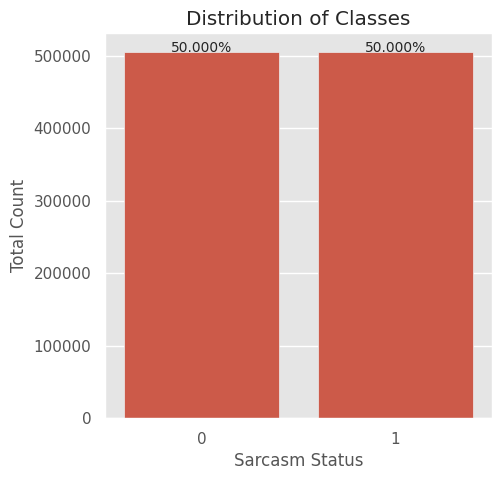

In [4]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.3f}%'.format((height/total)*100),
            ha="center")
plt.show()

In [5]:
# X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)
y_train = train_df['label']
y_test = test_df['label']
X_train = train_df['comment']
X_test = test_df['comment']

## Tokenization + embedding

In [6]:
# copied from github
MAX_LENGTH = 256  # Set the maximum sequence length for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='tf',
    pad_to_max_length=True,
    truncation=True
)

# Define class weights for handling imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Model

In [7]:
MAX_NUM_WORDS = len(tokenizer.get_vocab())
MAX_NUM_WORDS

30522

In [8]:
EMBEDDING_DIM = 128  # Word embedding size
LSTM_UNITS = 128

input_layer = Input(shape=(MAX_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH)(input_layer)
bi_lstm_layer = Bidirectional(LSTM(LSTM_UNITS))(embedding_layer)
dropout_layer = Dropout(0.5)(bi_lstm_layer)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

bi_lstm_model = Model(inputs=input_layer, outputs=output_layer)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### CSV Logger (for training curves)

In [13]:
from tensorflow.keras.callbacks import CSVLogger
# Define the CSVLogger callback
csv_logger = CSVLogger("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr19_BERT_BiLSTM_2epoch_other_ver_AdamW_training_history.csv", append=True)  # Replace with desired path
def checkpoint_callback():
    checkpoint_filepath = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr19_BERT_BiLSTM_2epoch_other_ver_AdamW_model.keras"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                          #  save_weights_only=True,  # Save only the best weights
                           monitor='val_accuracy',
                           mode = 'max',          # 'max' because we are looking for max validation acc
                           save_best_only=True,
                           verbose=1)
    return model_checkpoint_callback
# **removed early stopping because unneeded here
checkpoint_callback = checkpoint_callback()
callbacks = [checkpoint_callback, csv_logger]

# Compile the Bi-LSTM model
bi_lstm_model.compile(optimizer='adamw', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Bi-LSTM model
hist = bi_lstm_model.fit(X_train_encoded['input_ids'], y_train,
                         validation_data=(X_test_encoded['input_ids'], y_test), # new
                         epochs=2, batch_size=64, class_weight=class_weight_dict,
                             callbacks=callbacks) # new
history_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr19_BERT_BiLSTM_2epoch_other_ver_AdamW_model.pickle"
with open(history_path, 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# Evaluate the Bi-LSTM model
bi_lstm_loss, bi_lstm_accuracy = bi_lstm_model.evaluate(X_test_encoded['input_ids'], y_test)

print("Bi-LSTM Model - Loss:", bi_lstm_loss)
print("Bi-LSTM Model - Accuracy:", bi_lstm_accuracy)

Epoch 1/2
12636/12636 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7318 - loss: 0.5320
Epoch 1: val_accuracy improved from -inf to 0.74018, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr19_BERT_BiLSTM_2epoch_other_ver_AdamW_model.keras
12636/12636 ━━━━━━━━━━━━━━━━━━━━ 379s 30ms/step - accuracy: 0.7318 - loss: 0.5320 - val_accuracy: 0.7402 - val_loss: 0.5196
Epoch 2/2
12635/12636 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7626 - loss: 0.4875
Epoch 2: val_accuracy improved from 0.74018 to 0.74188, saving model to /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/BiLSTM_model/Apr19_BERT_BiLSTM_2epoch_other_ver_AdamW_model.keras
12636/12636 ━━━━━━━━━━━━━━━━━━━━ 380s 30ms/step - accuracy: 0.7626 - loss: 0.4875 - val_accuracy: 0.7419 - val_loss: 0.5169


NameError: name 'pickle' is not defined

## Performance evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

class_names = [str(i) for i in range(len(np.unique(y_test)))]
y_pred = bi_lstm_model.predict(X_test_encoded['input_ids']) # Convert the predicted probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int) # Get the true class labels from the test data generator

if len(y_test.shape) == 2:
    y_true_labels = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
else:
    y_true_labels = y_test  # Already class labels

accuracy = accuracy_score(y_test, y_pred_labels)
print("Testing Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred_labels)
print("Testing F1 Score:", f1)
print("The Accuracy is",accuracy_score(y_test,y_pred_labels))

3159/3159 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
Testing Accuracy: 0.7418754884599784
Testing F1 Score: 0.7243317485472794
The Accuracy is 0.7418754884599784


In [15]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names, digits=4)
print("Classification Report: ")
print( report)

Classification Report: 
              precision    recall  f1-score   support

           0     0.7146    0.8055    0.7573     50542
           1     0.7771    0.6782    0.7243     50541

    accuracy                         0.7419    101083
   macro avg     0.7459    0.7419    0.7408    101083
weighted avg     0.7459    0.7419    0.7408    101083



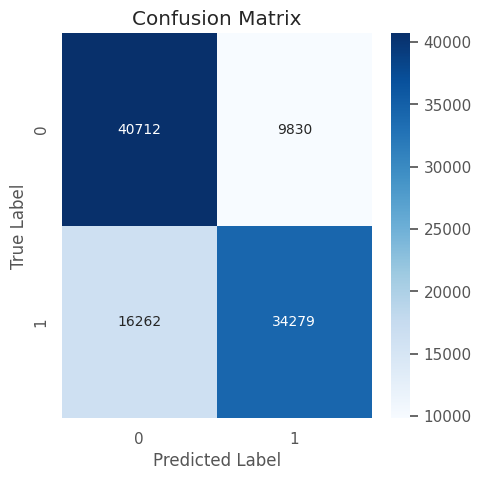

In [ ]:
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


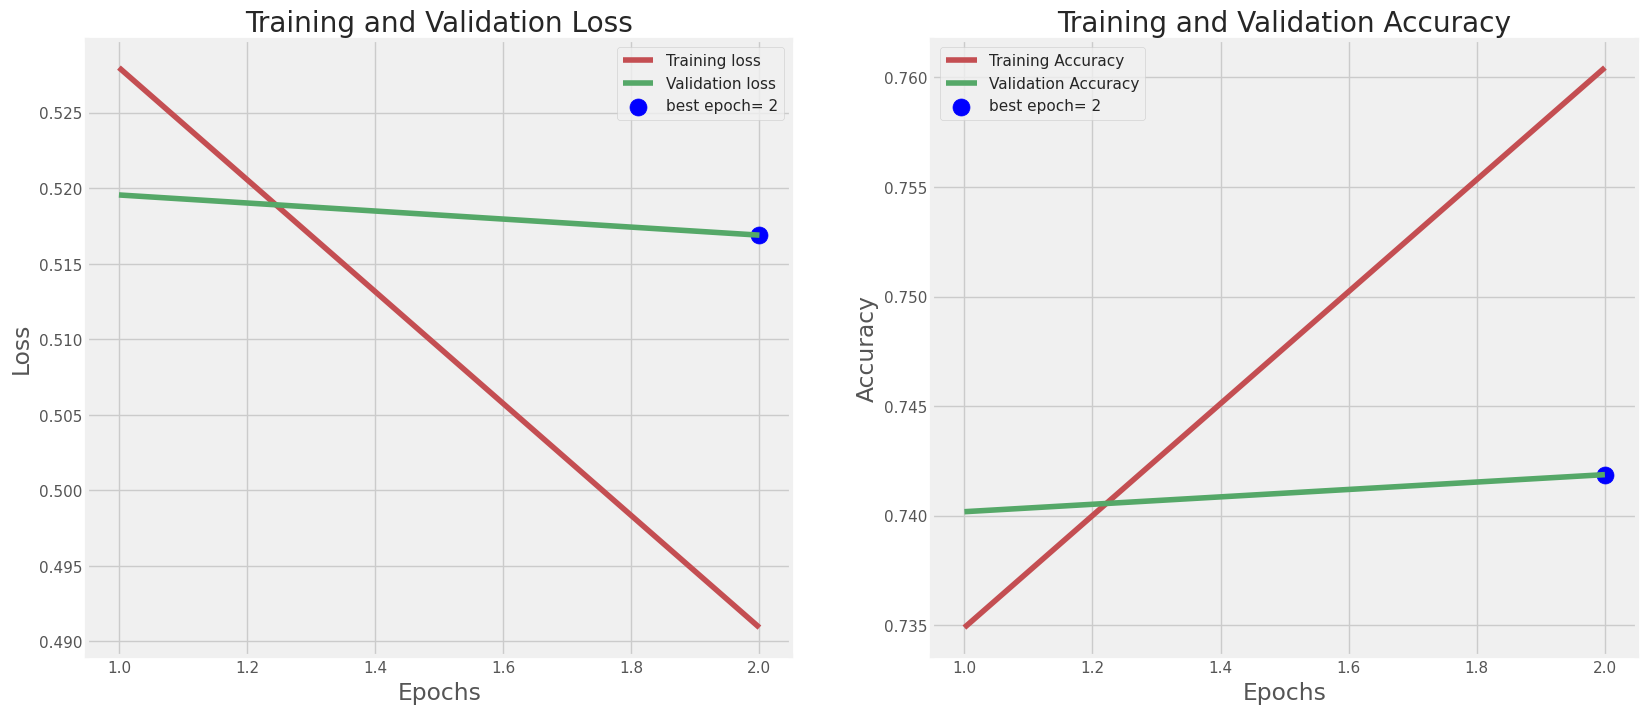

In [17]:
# Function to get true and predicted labels from the dataset
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()
plot_training(hist)
